    Obtain the TGSS and NVSS catalogues.
        TGSS: http://tgssadr.strw.leidenuniv.nl/doku.php
        NVSS: ftp://nvss.cv.nrao.edu/pub/nvss/CATALOG/ (152 MB) or mirrored https://heasarc.gsfc.nasa.gov/W3Browse/all/nvss.html
A bit of I/O required, reads NVSSCatalog.text and TGSSADR1_7sigma_catalog.tsv present in the current directory, into numpy arrays of RA,DEC

    Following Section 2.3 of https://arxiv.org/pdf/1609.01308.pdf, match TGSS and NVSS.
This only considers sources within 30'' (30 arcsec) of each other, that's our initial "good" value.
They also drop all non-one-to-one mappings, if two in TGSS match one in NVSS or one in TGSS matches two in NVSS all of the associations are dropped.

    Plot a histogram of the angular separation between matches.
current issue: we only have matches inbetween -40 and -39, why?!

    Using Equation 3 of the above paper, compute the spectral index ɑ and reproduce Figure 2.
pg. 4/6

In [10]:
import numpy as np
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

good = 30*1/3600

In [11]:
tgss = np.genfromtxt(
    fname="TGSSADR1_7sigma_catalog.tsv",
    delimiter='\t',
    skip_header=1,
    usecols=(1,3))
#Source_name,RA,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,
#Maj,E_Maj,Min,E_Min,PA,E_PA,RMS_noise,Source_code,Mosaic_name

In [12]:
with fits.open("CATALOG.FIT") as hdulist:
    data = hdulist[1].data
    nvss = np.column_stack((data['RA(2000)'],data['DEC(2000)']))
#     hdulist.info()
#     hdr = hdulist[0].header
#     print(repr(hdr))
#     cols = hdulist[1].columns
#     cols.info()    

In [13]:
print(np.shape(nvss),np.shape(tgss))
nvss = nvss[nvss[:,1].argsort()]
print(nvss)
tgss = tgss[tgss[:,1].argsort()]
print(tgss)

(1810672, 2) (623604, 2)
[[262.46038694 -40.43084868]
 [262.45377962 -40.42571561]
 [260.31880481 -40.4199181 ]
 ...
 [354.35724493  89.78046846]
 [186.13588316  89.78949487]
 [347.18068592  89.81903192]]
[[142.49432 -53.06924]
 [ 37.35616 -53.06686]
 [187.41508 -53.05964]
 ...
 [ 11.20567  89.4918 ]
 [ 16.46084  89.53076]
 [  3.31452  89.59118]]


In [14]:
# create 0.1deg bins of nvss,
#expand by 1000 *-* above and below to cover good
nvss_chunks = np.arange(-90,90,10,dtype=object)#np.zeros(18)
# nvss_chunks

chunkis = []#np.zeros(89*2)
count = 0
mark = round(nvss[0][1],1)-0.1

# finding the first element in each bin
for i,dec in enumerate(nvss[:,1]):    
    if mark < dec < mark+0.1:#1:
        chunkis.append(i)
        mark += 0.1#1
        
print(chunkis[:5],'...',chunkis[-5:])

[0, 3, 76, 678, 1820] ... [1810622, 1810638, 1810648, 1810661, 1810671]


In [15]:
nia,nib = round(nvss[0][1],1),round(nvss[-1][1],1)

bins = [x/10 for x in range(int((nia-0.1)*10),int((nib+0.11)*10))]
# bins.index(np.floor(-40.39*10)/10)
# print(nia,nib,len(chunkis),bins[:10])

In [22]:
# this takes at least 25 minutes to complete
match = []
bar = tqdm(total=len(tgss))

for i1,p1 in enumerate(tgss):
    #if i1%10000==0:
    #    print('at:',i1)
    if p1[1] < nia - 0.1:
        bar.update(1)
        continue
    elif p1[1] > nib + 0.1:
        break
    
    whichbin = bins.index(np.floor(p1[1]*10)/10)
    # look both ways, -1, 0, +1
    nslice = chunkis[whichbin-1],chunkis[whichbin+2]
    #print(p1[1],round(p1[1],1),nslice)
    
    for i2,p2 in enumerate(nvss[nslice[0]:nslice[1]]):
        # messes up near the poles with first condition
        
        """
        
        TO DO 
        
        
        """
        
        
        
        
        if abs(p1[0]-p2[0])<good and abs(p1[1]-p2[1])<good:
            match.append((p1,p2))
            #print('matched: ',p1,p2,sep='')
    bar.postfix = 'happy, matches = {}'.format(len(match))
    bar.update(1)
match = np.array(match)
# paper says 553301 tgss unique sources
np.save('matches2.npy', match)

KeyboardInterrupt: 

In [100]:
def dist(p1,p2):
    """given two points close on the unit sphere,
    return their geodesic distance,
    must be in radians!"""
    ra1,dec1,ra2,dec2 = p1[0],p1[1],p2[0],p2[1]
    #https://en.wikipedia.org/wiki/Great-circle_distance#Formulae
    decdiff = (dec1-dec2)/2
    radiff  = (ra1-ra2)/2
    better_circle = 2*np.arcsin(np.sqrt(np.sin(decdiff)**2 +\
                np.cos(dec1)*np.cos(dec2) * np.sin(radiff)**2))
    r = 1
    return better_circle*r

def degdist(p1,p2):
    """calls dist on argument points,
    after converting from deg to rad and back"""
    return 180/np.pi*dist([x*np.pi/180 for x in p1],[x*np.pi/180 for x in p2])

In [406]:
match = np.load('matches.npy')

# run with finer distance metric
finer = []
for m in match:
    #tgss,nvss
    p1,p2 = m
    if degdist(p1,p2) < good:
        finer.append(m)
finer = np.array(finer)

# filter out all non-one-to-one, 541195 total?
evenfiner = []
for i,m in enumerate(finer):
    p1,p2 = m
    wofiner = np.concatenate((finer[:i],finer[i+1:]))
    assert len(wofiner) == len(finer)-1
    tgsswoof = wofiner[:,0]
    nvsswoof = wofiner[:,1]
    
    if not p1 in tgsswoof and not p2 in nvsswoof:
        evenfiner.append(m)
evenfiner = np.array(evenfiner)

print('removed:',len(finer)-len(evenfiner))

removed: 61


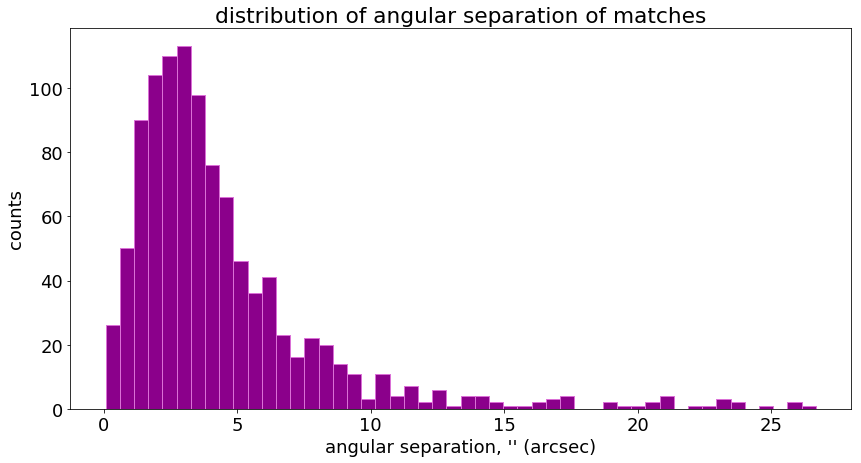

In [386]:
# create histogram of angular separation of matches
# create list of angular separations
seps = [degdist(m[0],m[1]) for m in evenfiner]
seps = [3600*val for val in seps]
# print(seps[:10])

plt.figure(figsize=(14,7))
plt.rcParams.update({'font.size': 18})
plt.hist(seps, bins=50,color = "darkmagenta", ec="orchid")
plt.xlabel("angular separation, '' (arcsec)")
plt.ylabel('counts')
plt.title('distribution of angular separation of matches')
# plt.show()
plt.savefig('hist.png',bbox_inches='tight')
# plt.clf()

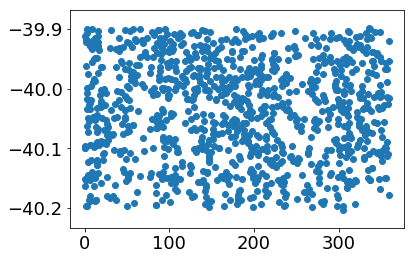

In [414]:
plt.scatter(evenfiner[:,0,0],evenfiner[:,0,1])
# bad ra
# evenfiner

In [306]:
# observed spectral index plot
matchedtgss = evenfiner[:,0]
matchednvss = evenfiner[:,1]

In [317]:
with fits.open("CATALOG.FIT") as hdulist:
    data = hdulist[1].data
    # jansky?!
    fnvss = np.column_stack((data['RA(2000)'],data['DEC(2000)'],data['P FLUX']))
fnvss = fnvss[fnvss[:,1].argsort()]

In [318]:
imatch = []
for i,p in enumerate(nvss):
    if p in matchednvss:
        imatch.append(i)
    # abuse of current issue
#     if p[1] > -39:
#         break
# print(imatch)
fnvss = fnvss[imatch]

In [314]:
ftgss = np.genfromtxt(
    fname="TGSSADR1_7sigma_catalog.tsv",
    delimiter='\t',
    skip_header=1,
    usecols=(1,3,5))
ftgss = ftgss[ftgss[:,1].argsort()]

In [315]:
imatch = []
for i,p in enumerate(tgss):
    if p in evenfiner[:,0]:
        imatch.append(i)
#     # abuse of current issue
#     if p[1] > -39:
#         break
ftgss = ftgss[imatch]
# this slicing has not worked correctly !*!
# print(ftgss)

In [348]:
# print(len(ftgss),len(fnvss),len(evenfiner))
# print(ftgss,fnvss,compmatch,sep='\n')

In [352]:
#eq.3
# filter for NaN's!
S_tgss = ftgss[:1038][:,2]
S_nvss = fnvss[:,2]
wherenice = []
for i in range(len(S_nvss)):
    if S_nvss[i]>0 and S_tgss[i]>0: 
        wherenice.append(i)
S_nvss = S_nvss[wherenice]
S_tgss = S_tgss[wherenice]
alpha = np.log(S_tgss/S_nvss)/np.log(1.4e9/150e6)

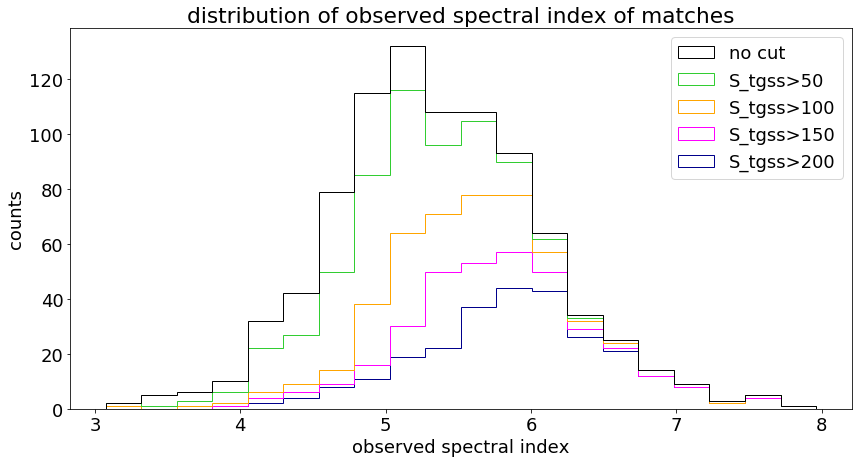

In [385]:
plt.rcParams.update({'font.size': 18})
allalpha = alpha,alpha[S_tgss>50],alpha[S_tgss>100],alpha[S_tgss>150],alpha[S_tgss>200]

fig,axis = plt.subplots(figsize=(14,7))
plt.hist(allalpha, bins=20, histtype='step', stacked=False, fill=False,\
         label=['no cut','S_tgss>50','S_tgss>100','S_tgss>150','S_tgss>200'],\
         color=['black','limegreen','orange','magenta','darkblue'])
# ax2.set_title('stack step (unfilled)') color = "darkgreen", ec="forestgreen",
plt.legend(loc='upper right')
handles, labels = axis.get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))
plt.xlabel("observed spectral index")
plt.ylabel('counts')
plt.title('distribution of observed spectral index of matches')
# plt.show()
plt.savefig('hist_alpha.png',bbox_inches='tight')
# plt.clf()

SyntaxError: invalid syntax (<ipython-input-393-a96a2bf70471>, line 1)

In [355]:
# aitoff hexbin for fig 1
# ctrl+enter to stay

887

In [ ]:
# degdist((34,-52),(34,-51.9))
# # 30''
# good = 30*1/3600
# match = 0
# for i1,p1 in enumerate(nvss):
#     if i1%100==0:
#         print(i1)
#     for i2,p2 in enumerate(tgss):
#         if degdist(p1,p2) < good:
#             #if abs(p1[0]-p2[0])<30*1/3600 and abs(p1[1]-p2[1])<30*1/3600:
#             match += 1
#             print('matched: ',p1,p2,sep='')

# A = np.array([[0.5,0.5],[0.9,0.1]])
# B = np.array([[0.5,0.5],[0.0,-0.2],[0.8,-0.9]])
# res = positionalmatching.main(A,B)
# print(res)
            
# import positionalmatching
# positionalmatching.main(nvss,tgss)    
    
# mark = -89
# starter = nvss[0][1]
# while mark < starter:
#     #chunkis.append('n')
#     mark += 1        
    #jump if band is empty
    #elif mark+1 < dec:1
    #    chunkis.append('n')
    #    mark += 1